# Programming Assignment 1: Learning Distributed Word Representations
**Version**: 1.2

**Changes by Version:** 
* (v1.1) <br>
	1. Part 1 Description: indicated that each word is associated with two embedding vectors and two biases <br>
	2. Part 1: Updated `calculate_log_co_occurence` to include the last pair of consecutive words as well <br>
	3. Part 2: Updated question description for 2.1 <br>
	4. Part 4: Updated answer requirement for 4.1 <br>
	5. (1.3) Fixed symmetric GLoVE gradient <br>
	6. (1.3) Clarified that W_tilde and b_tilde gradients also need to be implemented <br>
	7. (2) Removed extra space leading up to docstring for `compute_loss_derivative` <br>
* (v1.2) <br>
	1. (1.4) Updated the training function `train_GLoVE` to not use inplace update (e.g. `W = W - learning_rate * grad_W` instead), so the initial weight variables are not overwritten between asymmetric and symmetric GLoVE models. <br>
	2. (2) Noted that `compute_loss_derivative` input argument `target_mask` is 3D tensor with shape `[batch_size x context_len x 1]` 


**Version Release Date**: 2021-01-27

**Due Date**:Thursday, Feb.  4, at 11:59pm

Based on an assignment by George Dahl

For CSC413/2516 in Winter 2021 with Professor Jimmy Ba and Professor Bo Wang

**Submission:**
You must submit two files through MarkUs: 
1. [ ] A PDF file containing your writeup, titled *a1-writeup.pdf*, which will be the PDF export of this notebook (i.e., by printing this notebook webpage as PDF). Your writeup must be typed. There will be sections in the notebook for you to write your responses. Make sure that the relevant outputs (e.g. `print_gradients()` outputs, plots, etc.) are included and clearly visible. 
2. [ ] This `a1-code.ipynb` iPython Notebook. 

The programming assignments are individual work. See the Course Syllabus for detailed policies. 

You should attempt all questions for this assignment. Most of them can be answered at least partially even if you were unable to finish earlier questions. If you think your computational results are incorrect, please say so; that may help you get partial credit. 
    
The teaching assistants for this assignment are Harris Chan and Summer Tao. Send your email with subject "*\[CSC413\] PA1*" to mailto:csc413-2021-01-tas@cs.toronto.edu or post on Piazza with the tag `pa1`.
    
# Introduction
In this assignment we will learn about word embeddings and make neural networks learn about words.
We could try to match statistics about the words, or we could train a network that takes a sequence of words as input and learns to predict the word that comes next.
        
This assignment will ask you to implement a linear embedding and then the backpropagation computations for a neural language model and then run some experiments to analyze the learned representation.
The amount of code you have to write is very short but each line will require you to think very carefully.
You will need to derive the updates mathematically, and then implement them using matrix and vector operations in NumPy.

# Starter code and data

First, perform the required imports for your code:


In [4]:
import collections
import pickle
import numpy as np
import os
from tqdm import tqdm
import pylab
from six.moves.urllib.request import urlretrieve
import tarfile
import sys

TINY = 1e-30
EPS = 1e-4
nax = np.newaxis

If you're using colaboratory, this following script creates a folder - here we used 'CSC413/A1' - in order to download and store the data. If you're not using colaboratory, then set the path to wherever you want the contents to be stored at locally.

You can also manually download and unzip the data from [http://www.cs.toronto.edu/~jba/a1_data.tar.gz] and put them in the same folder as where you store this notebook. 

Feel free to use a different way to access the files *data.pk* , *partially_trained.pk*, and *raw_sentences.txt*. 

The file *raw_sentences.txt* contains the sentences that we will be using for this assignment.
These sentences are fairly simple ones and cover a vocabulary of only 250 words (+ 1 special `[MASK]` token word).





In [5]:
######################################################################
# Setup working directory
######################################################################
# Change this to a local path if running locally
%mkdir -p /content/CSC413/A1/
%cd /content/CSC413/A1

######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

/content/CSC413/A1


In [7]:
# Download the dataset and partially pre-trained model
get_file(fname='a1_data', 
                         origin='http://www.cs.toronto.edu/~jba/a1_data.tar.gz', 
                         untar=True)
drive_location = 'data'
PARTIALLY_TRAINED_MODEL = drive_location + '/' + 'partially_trained.pk'
data_location = drive_location + '/' + 'data.pk'

File path: data/a1_data.tar.gz
Extracting file.


We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets.
To inspect this data, run the following:

In [8]:
data = pickle.load(open(data_location, 'rb'))
print(data['vocab'][0]) # First word in vocab is [MASK] 
print(data['vocab'][1]) 
print(len(data['vocab'])) # Number of words in vocab
print(data['vocab']) # All the words in vocab
print(data['train_inputs'][:10]) # 10 example training instances

[MASK]
all
251
['[MASK]', 'all', 'set', 'just', 'show', 'being', 'money', 'over', 'both', 'years', 'four', 'through', 'during', 'go', 'still', 'children', 'before', 'police', 'office', 'million', 'also', 'less', 'had', ',', 'including', 'should', 'to', 'only', 'going', 'under', 'has', 'might', 'do', 'them', 'good', 'around', 'get', 'very', 'big', 'dr.', 'game', 'every', 'know', 'they', 'not', 'world', 'now', 'him', 'school', 'several', 'like', 'did', 'university', 'companies', 'these', 'she', 'team', 'found', 'where', 'right', 'says', 'people', 'house', 'national', 'some', 'back', 'see', 'street', 'are', 'year', 'home', 'best', 'out', 'even', 'what', 'said', 'for', 'federal', 'since', 'its', 'may', 'state', 'does', 'john', 'between', 'new', ';', 'three', 'public', '?', 'be', 'we', 'after', 'business', 'never', 'use', 'here', 'york', 'members', 'percent', 'put', 'group', 'come', 'by', '$', 'on', 'about', 'last', 'her', 'of', 'could', 'days', 'against', 'times', 'women', 'place', 'think'

Now `data` is a Python dict which contains the vocabulary, as well as the inputs and targets for all three splits of the data. `data['vocab']` is a list of the 251 words in the dictionary; `data['vocab'][0]` is the word with index 0, and so on. `data['train_inputs']` is a 372,500 x 4 matrix where each row gives the indices of the 4 consecutive context words for one of the 372,500 training cases.
The validation and test sets are handled analogously.

Even though you only have to modify two specific locations in the code, you may want to read through this code before starting the assignment. 

# Part 1: GLoVE Word Representations (2pts)

In this part of the assignment, you will implement a simplified version of the GLoVE embedding (please see the handout for detailed description of the algorithm) with the loss defined as

$$L(\{\mathbf{w}_i,\tilde{\mathbf{w}}_i,b_i, \tilde{b}_i\}_{i=1}^V) = \sum_{i,j=1}^V (\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij})^2$$.

Note that each word is represented by two $d$-dimensional embedding vectors $\mathbf{w}_i, \tilde{\mathbf{w}}_i$ and two scalar biases $b_i, \tilde{b}_i$.



Answer the following questions:

## 1.1.  GLoVE Parameter Count \[0pt\]
Given the vocabulary size $V$ and embedding dimensionality $d$, how many parameters does the GLoVE model have?  Note that each word in the vocabulary is associated with 2 embedding vectors and 2 biases.

1.1 **Answer**: Since the dimension of $\boldsymbol{w}_i$ and $\boldsymbol{w}_i$ are $d$ and the dimension of the biases are $1$, there are $2d + 2$ parameters to train for each vocabulary. Thus, we can get that the GLoVe model have $2V(d + 1)$ trainable parameters.

## 1.2. Expression for gradient $\frac{\partial L}{\partial \mathbf{w}_i}$ \[1pt\]

Write the expression for $\frac{\partial L}{\partial \mathbf{w}_i}$, the gradient of the loss function $L$ with respect to one parameter vector $\mathbf{w}_i$. The gradient should be a function of $\mathbf{w}, \tilde{\mathbf{w}}, b, \tilde{b}, X$ with appropriate subscripts (if any). 

1.2 **Answer**: According to the given loss function, we can get $\frac{\partial L}{\partial \boldsymbol{w}_i}$ should be
        \begin{align*}
            \frac{\partial L}{\partial \boldsymbol{w}_i} & = \frac{\partial}{\partial \boldsymbol{w}_i}\sum_{i,j=1}^{V}(\boldsymbol{w}_i^{T}\tilde{\boldsymbol{w}}_i + b_i + \tilde{b}_j - \log X_{ij})^2 \\
            & = 2\sum_{i,j=1}^{V}(\boldsymbol{w}_i^{T}\tilde{\boldsymbol{w}}_i + b_i + \tilde{b}_j - \log X_{ij})\tilde{\boldsymbol{w}}_i
        \end{align*}


## 1.3.  Implement the gradient update of GLoVE. \[1pt\]

**See** `YOUR CODE HERE` **Comment below for where to complete the code**


We have provided a few functions for training the embedding:

*   `calculate_log_co_occurence` computes the log co-occurrence matrix of a given corpus
*   `train_GLoVE` runs momentum gradient descent to optimize the embedding
*   `loss_GLoVE`: 
  * INPUT - $V\times d$ matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional); $V\times d$ matrix `W_tilde`; $V\times 1$ vector `b` (collection of $V$ bias terms); $V\times 1$ vector `b_tilde`; $V \times V$ log co-occurrence matrix. 
  * OUTPUT - loss of the GLoVE objective
*   `grad_GLoVE`: **TO BE IMPLEMENTED.**
  * INPUT:
      * $V\times d$ matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional), embedding for first word; 
      * $V\times d$ matrix `W_tilde`, embedding for second word; 
      * $V\times 1$ vector `b` (collection of $V$ bias terms); 
      * $V\times 1$ vector `b_tilde`, bias for second word; 
      * $V \times V$ log co-occurrence matrix. 
  * OUTPUT:
      * $V\times d$ matrix `grad_W` containing the gradient of the loss function w.r.t. `W`;
      * $V\times d$ matrix `grad_W_tilde` containing the gradient of the loss function w.r.t. `W_tilde`;
      * $V\times 1$ vector `grad_b` which is the gradient of the loss function w.r.t. `b`. 
      * $V\times 1$ vector `grad_b_tilde` which is the gradient of the loss function w.r.t. `b_tilde`. 

Run the code to compute the co-occurence matrix.
Make sure to add a 1 to the occurences, so there are no 0's in the matrix when we take the elementwise log of the matrix.


In [9]:
vocab_size = len(data['vocab']) # Number of vocabs

def calculate_log_co_occurence(word_data, symmetric=False):
  "Compute the log-co-occurence matrix for our data."
  log_co_occurence = np.zeros((vocab_size, vocab_size))
  for input in word_data:
    # Note: the co-occurence matrix may not be symmetric
    log_co_occurence[input[0], input[1]] += 1
    log_co_occurence[input[1], input[2]] += 1
    log_co_occurence[input[2], input[3]] += 1
    # If we want symmetric co-occurence can also increment for these.
    if symmetric:
      log_co_occurence[input[1], input[0]] += 1
      log_co_occurence[input[2], input[1]] += 1
      log_co_occurence[input[3], input[2]] += 1
  delta_smoothing = 0.5  # A hyperparameter.  You can play with this if you want.
  log_co_occurence += delta_smoothing  # Add delta so log doesn't break on 0's.
  log_co_occurence = np.log(log_co_occurence)
  return log_co_occurence


In [10]:
asym_log_co_occurence_train = calculate_log_co_occurence(data['train_inputs'], symmetric=False)
asym_log_co_occurence_valid = calculate_log_co_occurence(data['valid_inputs'], symmetric=False)

* [ ] **TO BE IMPLEMENTED**: Calculate the gradient of the loss function w.r.t. the parameters $W$, $\tilde{W}$, $\mathbf{b}$, and $\mathbf{b}$. You should vectorize the computation, i.e. not loop over every word.

In [105]:
def loss_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence):
  "Compute the GLoVE loss."
  n,_ = log_co_occurence.shape
  if W_tilde is None and b_tilde is None:
    return np.sum((W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)**2)
  else:
    return np.sum((W @ W_tilde.T + b @ np.ones([1,n]) + np.ones([n,1])@b_tilde.T - log_co_occurence)**2)

def grad_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence):
  "Return the gradient of GLoVE objective w.r.t W and b."
  "INPUT: W - Vxd; W_tilde - Vxd; b - Vx1; b_tilde - Vx1; log_co_occurence: VxV"
  "OUTPUT: grad_W - Vxd; grad_W_tilde - Vxd, grad_b - Vx1, grad_b_tilde - Vx1"
  n,_ = log_co_occurence.shape
  
  if not W_tilde is None and not b_tilde is None:
  ###########################   YOUR CODE HERE  ##############################
    loss = (W @ W_tilde.T + b @ np.ones([1,n]) + np.ones([n,1]) @ b_tilde.T - (log_co_occurence))
    grad_W = 2 * (loss @ W_tilde)
    grad_W_tilde = 2 * (loss.T @ W)
    grad_b = 2 * (np.ones([1,n]) @ loss).T
    grad_b_tilde = 2 * (np.ones([1,n]) @ loss).T
  ############################################################################
  else:
    loss = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - 0.5*(log_co_occurence + log_co_occurence.T))
    grad_W = 4 *(W.T @ loss).T
    grad_W_tilde = None
    grad_b = 4 * (np.ones([1,n]) @ loss).T
    grad_b_tilde = None
  
  return grad_W, grad_W_tilde, grad_b, grad_b_tilde

def train_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=False):
  "Traing W and b according to GLoVE objective."
  n,_ = log_co_occurence_train.shape
  learning_rate = 0.05 / n  # A hyperparameter.  You can play with this if you want.
  for epoch in range(n_epochs):
    grad_W, grad_W_tilde, grad_b, grad_b_tilde = grad_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence_train)
    W = W - learning_rate * grad_W
    b = b - learning_rate * grad_b
    if not grad_W_tilde is None and not grad_b_tilde is None:
      W_tilde = W_tilde - learning_rate * grad_W_tilde
      b_tilde = b_tilde - learning_rate * grad_b_tilde
    train_loss, valid_loss = loss_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence_train), loss_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence_valid)
    if do_print:
      print(f"Train Loss: {train_loss}, valid loss: {valid_loss}, grad_norm: {np.sum(grad_W**2)}")
  return W, W_tilde, b, b_tilde, train_loss, valid_loss

## 1.4. Effect of embedding dimension $d$ \[0pt\]
Train the both the symmetric and asymmetric GLoVe model with varying dimensionality $d$ by running the cell below. Comment on:
1. Which $d$ leads to optimal validation performance for the asymmetric and symmetric models?
2. Why does / doesn't larger $d$ always lead to better validation error? 
3. Which model is performing better, and why?


1.4 Answer: **\*\*TODO: Write Part 1.4 answer here\*\***

Train the GLoVE model for a range of embedding dimensions

In [109]:
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.
# embedding_dims = np.array([1, 2, 10, 128, 256])
embedding_dims = np.array([1, 2, 4, 8, 10, 20, 30, 50, 80, 100, 128, 150, 176, 200, 228, 256])  # Play with this
# Store the final losses for graphing
asymModel_asymCoOc_final_train_losses, asymModel_asymCoOc_final_val_losses = [], []
symModel_asymCoOc_final_train_losses, symModel_asymCoOc_final_val_losses = [], []
Asym_W_final_2d, Asym_b_final_2d, Asym_W_tilde_final_2d, Asym_b_tilde_final_2d = None, None, None, None
W_final_2d, b_final_2d = None, None
do_print = False  # If you want to see diagnostic information during training

for embedding_dim in tqdm(embedding_dims):
  init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
  W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
  W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
  b = init_variance * np.random.normal(size=(vocab_size, 1))
  b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))
  if do_print:
    print(f"Training for embedding dimension: {embedding_dim}")
  
  # Train Asym model on Asym Co-Oc matrix
  Asym_W_final, Asym_W_tilde_final, Asym_b_final, Asym_b_tilde_final, train_loss, valid_loss = train_GLoVE(W, W_tilde, b, b_tilde, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
  if embedding_dim == 2:
    # Save a parameter copy if we are training 2d embedding for visualization later
    Asym_W_final_2d = Asym_W_final
    Asym_W_tilde_final_2d = Asym_W_tilde_final
    Asym_b_final_2d = Asym_b_final
    Asym_b_tilde_final_2d = Asym_b_tilde_final
  asymModel_asymCoOc_final_train_losses += [train_loss]
  asymModel_asymCoOc_final_val_losses += [valid_loss]
  if do_print:
    print(f"Final validation loss: {valid_loss}")
  
  # Train Sym model on Asym Co-Oc matrix
  W_final, W_tilde_final, b_final, b_tilde_final, train_loss, valid_loss = train_GLoVE(W, None, b, None, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
  if embedding_dim == 2:
    # Save a parameter copy if we are training 2d embedding for visualization later
    W_final_2d = W_final
    b_final_2d = b_final
  symModel_asymCoOc_final_train_losses += [train_loss]
  symModel_asymCoOc_final_val_losses += [valid_loss]
  if do_print:
    print(f"Final validation loss: {valid_loss}")

100%|██████████| 16/16 [01:43<00:00,  6.44s/it]


Plot the training and validation losses against the embedding dimension.

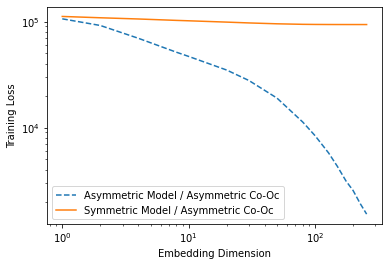

In [110]:
pylab.loglog(embedding_dims, asymModel_asymCoOc_final_train_losses, label="Asymmetric Model / Asymmetric Co-Oc", linestyle="--")
pylab.loglog(embedding_dims, symModel_asymCoOc_final_train_losses , label="Symmetric Model / Asymmetric Co-Oc")
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Training Loss")
pylab.legend()

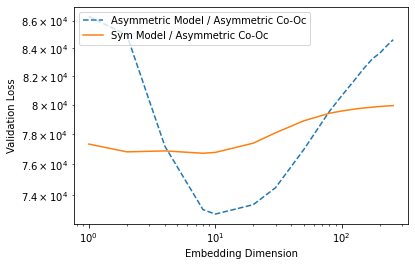

In [111]:
pylab.loglog(embedding_dims, asymModel_asymCoOc_final_val_losses, label="Asymmetric Model / Asymmetric Co-Oc", linestyle="--")
pylab.loglog(embedding_dims, symModel_asymCoOc_final_val_losses , label="Sym Model / Asymmetric Co-Oc")
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Validation Loss")
pylab.legend(loc="upper left")

# Part 2: Network Architecture (2pts)
See the handout for the written questions in this part.

## Answer the following questions

## 2.1. Number of parameters in neural network model \[1pt\]

Assume in general that we have $V$ words in the dictionary and use the previous $N$ words as inputs. Suppose we use a $D$-dimensional word embedding and a hidden layer with $H$ hidden units. The trainable parameters of the model consist of 3 weight matrices and 2 sets of biases. What is the total number of trainable parameters in the model, as a function of $V,N,D,H$? 

In the diagram given, which part of the model (i.e., `word_embbeding_weights`, `embed_to_hid_weights`, `hid_to_output_weights`, `hid_bias`, or `output_bias`) has the largest number of trainable parameters if we have the constraint that $V \gg H > D > N$? Note: The symbol $\gg$ means ``much greater than" Explain your reasoning. 


2.1 Answer: Let's find the number of the trainable parameters of the word embedding weights first. Since there are $V$ words in the dictionary and the dimension of the word embedding layer is $N \times D$, we can get that there are $V \times D$ trainable parameters. \\
        For weights between the word embedding layer and the hidden layer, since there are $H$ units in the hidden layer, the dimension of the matrix that connects two layers should be $ND \times H$, which is the number of trainable parameters. \\
        Thus, for the biases of the hidden layer, there should be $H \times 1$ trainable parameters. \\
        Similarly, since the output layer consists of $V$ words, there are $V \times H$ trainable parameters for weights between the hidden layer and the output layer. \\
        Thus, for the biases of the output layer, there should be $V \times 1$ trainable parameters. \\
        Since $V$ is much larger than other variables, we only need to consider the part that depends on $V$. Thus, we can get that weights between the hidden layer and the output layer, $hid\_to\_output\_weights$, has the largest number of trainable parameters since $H > D$.

## 2.2 Number of parameters in $n$-gram model \[1pt\]
Another method for predicting the next words is an n-gram model, which was mentioned in Lecture 3. If we wanted to use an n-gram model with the same context length $N$ as our network, we'd need to store the counts of all possible $(N+1)$-grams. If we stored all the counts explicitly, how many entries would this table have? 


2.2 Answer: For each gram, we can choose any word from $V$ words. Thus, there are $V^N$ number of combinations for the previous $N$ words. For the prediction, since the output layer is a softmax over the $V$ words, there are $V$ words. Thus, there are $V^{N+1}$ entries in the $n$-gram model scale with $N$.




## 2.3. Comparing neural network and $n$-gram model scaling \[0pt\]
How do the parameters in the neural network model scale with the number of context words $N$ versus how the number of entries in the $n$-gram model scale with $N$? [0pt]

2.3 Answer: **\*\*TODO: Write Part 2.3 answer here\*\***

# Part 3: Training the model (3pts)

We will modify the architecture slightly from the previous section, inspired by BERT \citep{devlin2018bert}. Instead of having only one output, the architecture will now take in $N=4$ context words, and also output predictions for $N=4$ words. See Figure 2 diagram in the handout for the diagram of this architecture. 

During training, we randomly sample one of the $N$ context words to replace with a `[MASK]` token. The goal is for the network to predict the word that was masked, at the corresponding output word position. 
In practice, this `[MASK]` token is assigned the index 0 in our dictionary. 
The weights $W^{(2)}$ = `hid_to_output_weights` now has the shape $NV \times H$, as the output layer has $NV$ neurons, where the first $V$ output units are for predicting the first word, then the next $V$ are for predicting the second word, and so on. 
    We call this as *concatenating* output uniits across all word positions, i.e. the $(j + nV)$-th column is for the word $j$ in vocabulary for the $n$-th output word position. 
        Note here that the softmax is applied in chunks of $V$ as well, to give a valid probability distribution over the $V$ words. Only the output word positions that were masked in the input are included in the cross entropy loss calculation:
        
        
There are three classes defined in this part: `Params`, `Activations`, `Model`.
You will make changes to `Model`, but it may help to read through `Params` and `Activations` first.

$$C = -\sum_{i}^{B}\sum_{n}^{N}\sum_{j}^{V} m^{(i)}_{n} (t^{(i)}_{n,j} \log y^{(i)}_{n,j}),$$

Where $y^{(i)}_{n,j}$ denotes the output probability prediction from the neural network for the $i$-th training example for the word $j$ in the $n$-th output word, and $t^{(i)}_{n,j}$ is 1 if for the $i$-th training example, the word $j$ is the $n$-th word in context. Finally, $m^{(i)}_{n} \in \{0,1\}$ is a mask that is set to 1 if we are predicting the $n$-th word position for the $i$-th example (because we had masked that word in the input), and 0 otherwise.  


There are three classes defined in this part: `Params`, `Activations`, `Model`.
You will make changes to `Model`, but it may help to read through `Params` and `Activations` first.

In [112]:
class Params(object):
    """A class representing the trainable parameters of the model. This class has five fields:
    
           word_embedding_weights, a matrix of size V x D, where V is the number of words in the vocabulary
                   and D is the embedding dimension.
           embed_to_hid_weights, a matrix of size H x ND, where H is the number of hidden units. The first D
                   columns represent connections from the embedding of the first context word, the next D columns
                   for the second context word, and so on. There are N context words.
           hid_bias, a vector of length H
           hid_to_output_weights, a matrix of size NV x H
           output_bias, a vector of length NV"""

    def __init__(self, word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                 hid_bias, output_bias):
        self.word_embedding_weights = word_embedding_weights
        self.embed_to_hid_weights = embed_to_hid_weights
        self.hid_to_output_weights = hid_to_output_weights
        self.hid_bias = hid_bias
        self.output_bias = output_bias

    def copy(self):
        return self.__class__(self.word_embedding_weights.copy(), self.embed_to_hid_weights.copy(),
                              self.hid_to_output_weights.copy(), self.hid_bias.copy(), self.output_bias.copy())

    @classmethod
    def zeros(cls, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes all weights and biases to 0."""
        word_embedding_weights = np.zeros((vocab_size, embedding_dim))
        embed_to_hid_weights = np.zeros((num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.zeros((vocab_size * context_len, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    @classmethod
    def random_init(cls, init_wt, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes weights to small random values and biases to 0."""
        word_embedding_weights = np.random.normal(0., init_wt, size=(vocab_size, embedding_dim))
        embed_to_hid_weights = np.random.normal(0., init_wt, size=(num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.random.normal(0., init_wt, size=(vocab_size * context_len, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    ###### The functions below are Python's somewhat oddball way of overloading operators, so that
    ###### we can do arithmetic on Params instances. You don't need to understand this to do the assignment.

    def __mul__(self, a):
        return self.__class__(a * self.word_embedding_weights,
                              a * self.embed_to_hid_weights,
                              a * self.hid_to_output_weights,
                              a * self.hid_bias,
                              a * self.output_bias)

    def __rmul__(self, a):
        return self * a

    def __add__(self, other):
        return self.__class__(self.word_embedding_weights + other.word_embedding_weights,
                              self.embed_to_hid_weights + other.embed_to_hid_weights,
                              self.hid_to_output_weights + other.hid_to_output_weights,
                              self.hid_bias + other.hid_bias,
                              self.output_bias + other.output_bias)

    def __sub__(self, other):
        return self + -1. * other

In [113]:
class Activations(object):
    """A class representing the activations of the units in the network. This class has three fields:

        embedding_layer, a matrix of B x ND matrix (where B is the batch size, D is the embedding dimension,
                and N is the number of input context words), representing the activations for the embedding 
                layer on all the cases in a batch. The first D columns represent the embeddings for the 
                first context word, and so on.
        hidden_layer, a B x H matrix representing the hidden layer activations for a batch
        output_layer, a B x V matrix representing the output layer activations for a batch"""

    def __init__(self, embedding_layer, hidden_layer, output_layer):
        self.embedding_layer = embedding_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

def get_batches(inputs, batch_size, shuffle=True):
    """Divide a dataset (usually the training set) into mini-batches of a given size. This is a
    'generator', i.e. something you can use in a for loop. You don't need to understand how it
    works to do the assignment."""

    if inputs.shape[0] % batch_size != 0:
        raise RuntimeError('The number of data points must be a multiple of the batch size.')
    num_batches = inputs.shape[0] // batch_size

    if shuffle:
        idxs = np.random.permutation(inputs.shape[0])
        inputs = inputs[idxs, :]

    for m in range(num_batches):
        yield inputs[m * batch_size:(m + 1) * batch_size, :]

In this part of the assignment, you implement a method which computes the gradient using backpropagation.
To start you out, the *Model* class contains several important methods used in training:


*   `compute_activations` computes the activations of all units on a given input batch
*   `compute_loss` computes the total cross-entropy loss on a mini-batch
*   `evaluate` computes the average cross-entropy loss for a given set of inputs and targets

You will need to complete the implementation of two additional methods which are needed for training, and print the outputs of the gradients.

 ## 3.1 Implement gradient with respect to output layer inputs [1pt]
 `compute_loss_derivative` computes the derivative of the loss function with respect to the output layer inputs.
 
In other words, if $C$ is the cost function, and the softmax computation for the $j$-th word in vocabulary for the $n$-th output word position is:

$$y_{n,j} = \frac{e^{z_{n,j}}}{\sum_{l} e^{z_{n,l   }}}$$

This function should compute a $B \times NV$ matrix where the entries correspond to the partial derivatives $\partial C / \partial z_{j}^{n}$. Recall that the output units are concatenated across all positions, i.e. the $(j + nV)$-th column is for the word $j$ in vocabulary for the $n$-th output word position. 

## 3.2 Implement gradient with respect to parameters [1pt]
`back_propagate` is the function which computes the gradient of the loss with respect to model parameters using backpropagation.
It uses the derivatives computed by *compute_loss_derivative*.
Some parts are already filled in for you, but you need to compute the matrices of derivatives for `embed_to_hid_weights`, `hid_bias`, `hid_to_output_weights`, and `output_bias`.
These matrices have the same sizes as the parameter matrices (see previous section).

In order to implement backpropagation efficiently, you need to express the computations in terms of matrix operations, rather than *for* loops.
You should first work through the derivatives on pencil and paper.
First, apply the chain rule to compute the derivatives with respect to individual units, weights, and biases.
Next, take the formulas you've derived, and express them in matrix form.
You should be able to express all of the required computations using only matrix multiplication, matrix transpose, and elementwise operations --- no *for* loops!
If you want inspiration, read through the code for *Model.compute_activations* and try to understand how the matrix operations correspond to the computations performed by all the units in the network.
        
To make your life easier, we have provided the routine `checking.check_gradients`, which checks your gradients using finite differences.
You should make sure this check passes before continuing with the assignment.
 
 

In [114]:
class Model(object):
    """A class representing the language model itself. This class contains various methods used in training
    the model and visualizing the learned representations. It has two fields:

        params, a Params instance which contains the model parameters
        vocab, a list containing all the words in the dictionary; vocab[0] is the word with index
               0, and so on."""

    def __init__(self, params, vocab):
        self.params = params
        self.vocab = vocab

        self.vocab_size = len(vocab)
        self.embedding_dim = self.params.word_embedding_weights.shape[1]
        self.embedding_layer_dim = self.params.embed_to_hid_weights.shape[1]
        self.context_len = self.embedding_layer_dim // self.embedding_dim
        self.num_hid = self.params.embed_to_hid_weights.shape[0]

    def copy(self):
        return self.__class__(self.params.copy(), self.vocab[:])

    @classmethod
    def random_init(cls, init_wt, vocab, context_len, embedding_dim, num_hid):
        """Constructor which randomly initializes the weights to Gaussians with standard deviation init_wt
        and initializes the biases to all zeros."""
        params = Params.random_init(init_wt, len(vocab), context_len, embedding_dim, num_hid)
        return Model(params, vocab)

    def indicator_matrix(self, targets, mask_zero_index=True):
        """Construct a matrix where the (k + j*V)th entry of row i is 1 if the j-th target word
         for example i is k, and all other entries are 0.

         Note: if the j-th target word index is 0, this corresponds to the [MASK] token,
               and we set the entry to be 0. 
        """
        batch_size, context_len = targets.shape
        expanded_targets = np.zeros((batch_size, context_len * len(self.vocab)))
        targets_offset = np.repeat((np.arange(context_len) * len(self.vocab))[np.newaxis, :], batch_size, axis=0) # [[0, V, 2V], [0, V, 2V], ...]
        targets += targets_offset

        for c in range(context_len):
          expanded_targets[np.arange(batch_size), targets[:,c]] = 1.
          if mask_zero_index:
            # Note: Set the targets with index 0, V, 2V to be zero since it corresponds to the [MASK] token
            expanded_targets[np.arange(batch_size), targets_offset[:,c]] = 0. 
        return expanded_targets

    def compute_loss_derivative(self, output_activations, expanded_target_batch, target_mask):
        """Compute the derivative of the multiple target position cross-entropy loss function \n"
        
            For example:

         [y_{0} ....  y_{V-1}] [y_{V}, ..., y_{2*V-1}] [y_{2*V} ... y_{i,3*V-1}] [y_{3*V} ... y_{i,4*V-1}] 
                  
         Where for colum j + n*V,

            y_{j + n*V} = e^{z_{j + n*V}} / \sum_{m=0}^{V-1} e^{z_{m + n*V}}, for n=0,...,N-1

        This function should return a dC / dz matrix of size [batch_size x (vocab_size * context_len)],
        where each row i in dC / dz has columns 0 to V-1 containing the gradient the 1st output 
        context word from i-th training example, then columns vocab_size to 2*vocab_size - 1 for the 2nd
        output context word of the i-th training example, etc.
        
        C is the loss function summed acrossed all examples as well:

            C = -\sum_{i,j,n} mask_{i,n} (t_{i, j + n*V} log y_{i, j + n*V}), for j=0,...,V, and n=0,...,N

        where mask_{i,n} = 1 if the i-th training example has n-th context word as the target, 
        otherwise mask_{i,n} = 0.
        
        The arguments are as follows:

            output_activations - A [batch_size x (context_len * vocab_size)] tensor, 
                for the activations of the output layer, i.e. the y_j's.
            expanded_target_batch - A [batch_size (context_len * vocab_size)] tensor, 
                where expanded_target_batch[i,n*V:(n+1)*V] is the indicator vector for 
                the n-th context target word position, i.e. the (i, j + n*V) entry is 1 if the 
                i'th example, the context word at position n is j, and 0 otherwise.
            target_mask - A [batch_size x context_len x 1] tensor, where target_mask[i,n] = 1 
                if for the i'th example the n-th context word is a target position, otherwise 0
        
        Outputs:
            loss_derivative - A [batch_size x (context_len * vocab_size)] matrix,
                where loss_derivative[i,0:vocab_size] contains the gradient
                dC / dz_0 for the i-th training example gradient for 1st output 
                context word, and loss_derivative[i,vocab_size:2*vocab_size] for 
                the 2nd output context word of the i-th training example, etc.
        """

        ###########################   YOUR CODE HERE  ##############################
        # Loss
        loss = output_activations - expanded_target_batch
        expanded_mask = np.repeat(target_mask, self.vocab_size, axis=1).reshape(loss.shape)
        return np.multiply(expanded_mask, loss)
        ############################################################################

    def compute_loss(self, output_activations, expanded_target_batch):
        """Compute the total loss over a mini-batch. expanded_target_batch is the matrix obtained
        by calling indicator_matrix on the targets for the batch."""
        return -np.sum(expanded_target_batch * np.log(output_activations + TINY))

    def compute_activations(self, inputs):
        """Compute the activations on a batch given the inputs. Returns an Activations instance.
        You should try to read and understand this function, since this will give you clues for
        how to implement back_propagate."""

        batch_size = inputs.shape[0]
        if inputs.shape[1] != self.context_len:
            raise RuntimeError('Dimension of the input vectors should be {}, but is instead {}'.format(
                self.context_len, inputs.shape[1]))

        # Embedding layer
        # Look up the input word indies in the word_embedding_weights matrix
        embedding_layer_state = np.zeros((batch_size, self.embedding_layer_dim))
        for i in range(self.context_len):
            embedding_layer_state[:, i * self.embedding_dim:(i + 1) * self.embedding_dim] = \
                self.params.word_embedding_weights[inputs[:, i], :]

        # Hidden layer
        inputs_to_hid = np.dot(embedding_layer_state, self.params.embed_to_hid_weights.T) + \
                        self.params.hid_bias
        # Apply logistic activation function
        hidden_layer_state = 1. / (1. + np.exp(-inputs_to_hid))

        # Output layer
        inputs_to_softmax = np.dot(hidden_layer_state, self.params.hid_to_output_weights.T) + \
                            self.params.output_bias

        # Subtract maximum.
        # Remember that adding or subtracting the same constant from each input to a
        # softmax unit does not affect the outputs. So subtract the maximum to
        # make all inputs <= 0. This prevents overflows when computing their exponents.
        inputs_to_softmax -= inputs_to_softmax.max(1).reshape((-1, 1))

        # Take softmax along each V chunks in the output layer
        output_layer_state = np.exp(inputs_to_softmax)
        output_layer_state_shape = output_layer_state.shape
        output_layer_state = output_layer_state.reshape((-1, self.context_len, len(self.vocab)))
        output_layer_state /= output_layer_state.sum(axis=-1, keepdims=True) # Softmax along each target word
        output_layer_state = output_layer_state.reshape(output_layer_state_shape) # Flatten back 

        return Activations(embedding_layer_state, hidden_layer_state, output_layer_state)

    def back_propagate(self, input_batch, activations, loss_derivative):
        """Compute the gradient of the loss function with respect to the trainable parameters
        of the model. The arguments are as follows:

             input_batch - the indices of the context words
             activations - an Activations class representing the output of Model.compute_activations
             loss_derivative - the matrix of derivatives computed by compute_loss_derivative
             
        Part of this function is already completed, but you need to fill in the derivative
        computations for hid_to_output_weights_grad, output_bias_grad, embed_to_hid_weights_grad,
        and hid_bias_grad. See the documentation for the Params class for a description of what
        these matrices represent."""

        # The matrix with values dC / dz_j, where dz_j is the input to the jth hidden unit,
        # i.e. h_j = 1 / (1 + e^{-z_j})
        hid_deriv = np.dot(loss_derivative, self.params.hid_to_output_weights) \
                    * activations.hidden_layer * (1. - activations.hidden_layer)

        ###########################   YOUR CODE HERE  ##############################
        hid_to_output_weights_grad = loss_derivative.T @ activations.hidden_layer
        output_bias_grad = np.sum(loss_derivative, axis=0)
        embed_to_hid_weights_grad = hid_deriv.T @ activations.embedding_layer
        hid_bias_grad = np.sum(hid_deriv, axis=0)
        ############################################################################

        # The matrix of derivatives for the embedding layer
        embed_deriv = np.dot(hid_deriv, self.params.embed_to_hid_weights)

        # Embedding layer
        word_embedding_weights_grad = np.zeros((self.vocab_size, self.embedding_dim))
        for w in range(self.context_len):
            word_embedding_weights_grad += np.dot(self.indicator_matrix(input_batch[:, w:w+1], mask_zero_index=False).T,
                                                  embed_deriv[:, w * self.embedding_dim:(w + 1) * self.embedding_dim])

        return Params(word_embedding_weights_grad, embed_to_hid_weights_grad, hid_to_output_weights_grad,
                      hid_bias_grad, output_bias_grad)

    def sample_input_mask(self, batch_size):
        """Samples a binary mask for the inputs of size batch_size x context_len
        For each row, at most one element will be 1.
        """
        mask_idx = np.random.randint(self.context_len, size=(batch_size,))
        mask = np.zeros((batch_size, self.context_len), dtype=np.int)# Convert to one hot B x N, B batch size, N context len
        mask[np.arange(batch_size), mask_idx] = 1
        return mask
    
    def evaluate(self, inputs, batch_size=100):
        """Compute the average cross-entropy over a dataset.

            inputs: matrix of shape D x N"""

        ndata = inputs.shape[0]

        total = 0.
        for input_batch in get_batches(inputs, batch_size):
            mask = self.sample_input_mask(batch_size)
            input_batch_masked = input_batch * (1 - mask)
            activations = self.compute_activations(input_batch_masked)
            target_batch_masked = input_batch * mask
            expanded_target_batch = self.indicator_matrix(target_batch_masked)
            cross_entropy = -np.sum(expanded_target_batch * np.log(activations.output_layer + TINY))
            total += cross_entropy

        return total / float(ndata)

    def display_nearest_words(self, word, k=10):
        """List the k words nearest to a given word, along with their distances."""

        if word not in self.vocab:
            print('Word "{}" not in vocabulary.'.format(word))
            return

        # Compute distance to every other word.
        idx = self.vocab.index(word)
        word_rep = self.params.word_embedding_weights[idx, :]
        diff = self.params.word_embedding_weights - word_rep.reshape((1, -1))
        distance = np.sqrt(np.sum(diff ** 2, axis=1))

        # Sort by distance.
        order = np.argsort(distance)
        order = order[1:1 + k]  # The nearest word is the query word itself, skip that.
        for i in order:
            print('{}: {}'.format(self.vocab[i], distance[i]))

    def word_distance(self, word1, word2):
        """Compute the distance between the vector representations of two words."""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))

        idx1, idx2 = self.vocab.index(word1), self.vocab.index(word2)
        word_rep1 = self.params.word_embedding_weights[idx1, :]
        word_rep2 = self.params.word_embedding_weights[idx2, :]
        diff = word_rep1 - word_rep2
        return np.sqrt(np.sum(diff ** 2))

## 3.3 Print the gradients [1pt]

To make your life easier, we have provided the routine `check_gradients`, which checks your gradients using finite differences.
        You should make sure this check passes before continuing with the assignment. Once `check_gradients()` passes, call `print_gradients()` and include its output in your write-up. 

In [115]:
def relative_error(a, b):
    return np.abs(a - b) / (np.abs(a) + np.abs(b))


def check_output_derivatives(model, input_batch, target_batch):
    def softmax(z):
        z = z.copy()
        z -= z.max(-1, keepdims=True)
        y = np.exp(z)
        y /= y.sum(-1, keepdims=True)
        return y

    batch_size = input_batch.shape[0]
    z = np.random.normal(size=(batch_size, model.context_len, model.vocab_size))
    y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
    z = z.reshape((batch_size, model.context_len * model.vocab_size))

    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = expanded_target_batch.reshape(-1, model.context_len, len(model.vocab)).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(y, expanded_target_batch, target_mask)

    if loss_derivative is None:
        print('Loss derivative not implemented yet.')
        return False

    if loss_derivative.shape != (batch_size, model.vocab_size * model.context_len):
        print('Loss derivative should be size {} but is actually {}.'.format(
            (batch_size, model.vocab_size), loss_derivative.shape))
        return False

    def obj(z):
        z = z.reshape((-1, model.context_len, model.vocab_size))
        y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
        return model.compute_loss(y, expanded_target_batch)

    for count in range(1000):
        i, j = np.random.randint(0, loss_derivative.shape[0]), np.random.randint(0, loss_derivative.shape[1])

        z_plus = z.copy()
        z_plus[i, j] += EPS
        obj_plus = obj(z_plus)

        z_minus = z.copy()
        z_minus[i, j] -= EPS
        obj_minus = obj(z_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        rel = relative_error(empirical, loss_derivative[i, j])
        if rel > 1e-4:
            print('The loss derivative has a relative error of {}, which is too large.'.format(rel))
            return False

    print('The loss derivative looks OK.')
    return True


def check_param_gradient(model, param_name, input_batch, target_batch):
    activations = model.compute_activations(input_batch)
    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = expanded_target_batch.reshape(-1, model.context_len, len(model.vocab)).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, target_mask)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    def obj(model):
        activations = model.compute_activations(input_batch)
        return model.compute_loss(activations.output_layer, expanded_target_batch)

    dims = getattr(model.params, param_name).shape
    is_matrix = (len(dims) == 2)

    if getattr(param_gradient, param_name).shape != dims:
        print('The gradient for {} should be size {} but is actually {}.'.format(
            param_name, dims, getattr(param_gradient, param_name).shape))
        return

    for count in range(1000):
        if is_matrix:
            slc = np.random.randint(0, dims[0]), np.random.randint(0, dims[1])
        else:
            slc = np.random.randint(dims[0])

        model_plus = model.copy()
        getattr(model_plus.params, param_name)[slc] += EPS
        obj_plus = obj(model_plus)

        model_minus = model.copy()
        getattr(model_minus.params, param_name)[slc] -= EPS
        obj_minus = obj(model_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        exact = getattr(param_gradient, param_name)[slc]
        rel = relative_error(empirical, exact)
        if rel > 3e-4:
            import pdb; pdb.set_trace()
            print('The loss derivative has a relative error of {}, which is too large for param {}.'.format(rel, param_name))
            return False

    print('The gradient for {} looks OK.'.format(param_name))


def load_partially_trained_model():
    obj = pickle.load(open(PARTIALLY_TRAINED_MODEL, 'rb'))
    params = Params(obj['word_embedding_weights'], obj['embed_to_hid_weights'],
                                   obj['hid_to_output_weights'], obj['hid_bias'],
                                   obj['output_bias'])
    vocab = obj['vocab']
    return Model(params, vocab)


def check_gradients():
    """Check the computed gradients using finite differences."""
    np.random.seed(0)

    np.seterr(all='ignore')  # suppress a warning which is harmless

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs = data_obj['train_inputs']
    input_batch = train_inputs[:100, :]
    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
    target_batch_masked = input_batch * mask
 
    if not check_output_derivatives(model, input_batch_masked, target_batch_masked):
        return

    for param_name in ['word_embedding_weights', 'embed_to_hid_weights', 'hid_to_output_weights',
                       'hid_bias', 'output_bias']:
        input_batch_masked = input_batch * (1 - mask)
        target_batch_masked = input_batch * mask
        check_param_gradient(model, param_name, input_batch_masked, target_batch_masked)


def print_gradients():
    """Print out certain derivatives for grading."""
    np.random.seed(0)

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs = data_obj['train_inputs']
    input_batch = train_inputs[:100, :]

    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
    activations = model.compute_activations(input_batch_masked)
    target_batch_masked = input_batch * mask
    expanded_target_batch = model.indicator_matrix(target_batch_masked)
    target_mask = expanded_target_batch.reshape(-1, model.context_len, len(model.vocab)).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, target_mask)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    print('loss_derivative[2, 5]', loss_derivative[2, 5])
    print('loss_derivative[2, 121]', loss_derivative[2, 121])
    print('loss_derivative[5, 33]', loss_derivative[5, 33])
    print('loss_derivative[5, 31]', loss_derivative[5, 31])
    print()
    print('param_gradient.word_embedding_weights[27, 2]', param_gradient.word_embedding_weights[27, 2])
    print('param_gradient.word_embedding_weights[43, 3]', param_gradient.word_embedding_weights[43, 3])
    print('param_gradient.word_embedding_weights[22, 4]', param_gradient.word_embedding_weights[22, 4])
    print('param_gradient.word_embedding_weights[2, 5]', param_gradient.word_embedding_weights[2, 5])
    print()
    print('param_gradient.embed_to_hid_weights[10, 2]', param_gradient.embed_to_hid_weights[10, 2])
    print('param_gradient.embed_to_hid_weights[15, 3]', param_gradient.embed_to_hid_weights[15, 3])
    print('param_gradient.embed_to_hid_weights[30, 9]', param_gradient.embed_to_hid_weights[30, 9])
    print('param_gradient.embed_to_hid_weights[35, 21]', param_gradient.embed_to_hid_weights[35, 21])
    print()
    print('param_gradient.hid_bias[10]', param_gradient.hid_bias[10])
    print('param_gradient.hid_bias[20]', param_gradient.hid_bias[20])
    print()
    print('param_gradient.output_bias[0]', param_gradient.output_bias[0])
    print('param_gradient.output_bias[1]', param_gradient.output_bias[1])
    print('param_gradient.output_bias[2]', param_gradient.output_bias[2])
    print('param_gradient.output_bias[3]', param_gradient.output_bias[3])


In [116]:
# Run this to check if your implement gradients matches the finite difference within tolerance
# Note: this may take a few minutes to go through all the checks
check_gradients()                                   

The loss derivative looks OK.
The gradient for word_embedding_weights looks OK.
The gradient for embed_to_hid_weights looks OK.
The gradient for hid_to_output_weights looks OK.
The gradient for hid_bias looks OK.
The gradient for output_bias looks OK.


In [117]:
# Run this to print out the gradients
print_gradients()

loss_derivative[2, 5] 0.0
loss_derivative[2, 121] 0.0
loss_derivative[5, 33] 0.0
loss_derivative[5, 31] 0.0

param_gradient.word_embedding_weights[27, 2] 0.0
param_gradient.word_embedding_weights[43, 3] 0.011596892511489458
param_gradient.word_embedding_weights[22, 4] -0.0222670623817297
param_gradient.word_embedding_weights[2, 5] 0.0

param_gradient.embed_to_hid_weights[10, 2] 0.3793257091930164
param_gradient.embed_to_hid_weights[15, 3] 0.01604516132110917
param_gradient.embed_to_hid_weights[30, 9] -0.4312854367997419
param_gradient.embed_to_hid_weights[35, 21] 0.06679896665436337

param_gradient.hid_bias[10] 0.023428803123345148
param_gradient.hid_bias[20] -0.024370452378874197

param_gradient.output_bias[0] 0.000970106146902794
param_gradient.output_bias[1] 0.16868946274763222
param_gradient.output_bias[2] 0.0051664774143909235
param_gradient.output_bias[3] 0.15096226471814364


## 3.4 Run model trainin [0pt]

Once you've implemented the gradient computation, you'll need to train the model.
The function *train* implements the main training procedure.
It takes two arguments:


*   `embedding_dim`: The number of dimensions in the distributed representation.
*   `num_hid`: The number of hidden units


As the model trains, the script prints out some numbers that tell you how well the training is going.
It shows:


*   The cross entropy on the last 100 mini-batches of the training set. This is shown after every 100 mini-batches.
*   The cross entropy on the entire validation set every 1000 mini-batches of training.

At the end of training, this function shows the cross entropies on the training, validation and test sets.
It will return a *Model* instance.

In [118]:
_train_inputs = None
_train_targets = None
_vocab = None

DEFAULT_TRAINING_CONFIG = {'batch_size': 100,  # the size of a mini-batch
                           'learning_rate': 0.1,  # the learning rate
                           'momentum': 0.9,  # the decay parameter for the momentum vector
                           'epochs': 50,  # the maximum number of epochs to run
                           'init_wt': 0.01,  # the standard deviation of the initial random weights
                           'context_len': 4,  # the number of context words used
                           'show_training_CE_after': 100,  # measure training error after this many mini-batches
                           'show_validation_CE_after': 1000,  # measure validation error after this many mini-batches
                           }


def find_occurrences(word1, word2, word3):
    """Lists all the words that followed a given tri-gram in the training set and the number of
    times each one followed it."""

    # cache the data so we don't keep reloading
    global _train_inputs, _train_targets, _vocab
    if _train_inputs is None:
        data_obj = pickle.load(open(data_location, 'rb'))
        _vocab = data_obj['vocab']
        _train_inputs, _train_targets = data_obj['train_inputs'], data_obj['train_targets']

    if word1 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
    if word2 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
    if word3 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

    idx1, idx2, idx3 = _vocab.index(word1), _vocab.index(word2), _vocab.index(word3)
    idxs = np.array([idx1, idx2, idx3])

    matches = np.all(_train_inputs == idxs.reshape((1, -1)), 1)

    if np.any(matches):
        counts = collections.defaultdict(int)
        for m in np.where(matches)[0]:
            counts[_vocab[_train_targets[m]]] += 1

        word_counts = sorted(list(counts.items()), key=lambda t: t[1], reverse=True)
        print('The tri-gram "{} {} {}" was followed by the following words in the training set:'.format(
            word1, word2, word3))
        for word, count in word_counts:
            if count > 1:
                print('    {} ({} times)'.format(word, count))
            else:
                print('    {} (1 time)'.format(word))
    else:
        print('The tri-gram "{} {} {}" did not occur in the training set.'.format(word1, word2, word3))


def train(embedding_dim, num_hid, config=DEFAULT_TRAINING_CONFIG):
    """This is the main training routine for the language model. It takes two parameters:

        embedding_dim, the dimension of the embedding space
        num_hid, the number of hidden units."""
    # For reproducibility
    np.random.seed(123)

    # Load the data
    data_obj = pickle.load(open(data_location, 'rb'))
    vocab = data_obj['vocab']
    train_inputs = data_obj['train_inputs']
    valid_inputs = data_obj['valid_inputs']
    test_inputs = data_obj['test_inputs']

    # Randomly initialize the trainable parameters
    model = Model.random_init(config['init_wt'], vocab, config['context_len'], embedding_dim, num_hid)

    # Variables used for early stopping
    best_valid_CE = np.infty
    end_training = False

    # Initialize the momentum vector to all zeros
    delta = Params.zeros(len(vocab), config['context_len'], embedding_dim, num_hid)

    this_chunk_CE = 0.
    batch_count = 0
    for epoch in range(1, config['epochs'] + 1):
        if end_training:
            break

        print()
        print('Epoch', epoch)

        for m, (input_batch) in enumerate(get_batches(train_inputs, config['batch_size'])):
            batch_count += 1

            # For each example (row in input_batch), select one word to mask out
            mask = model.sample_input_mask(config['batch_size'])
            input_batch_masked = input_batch * (1 - mask) # We only zero out one word per row
            target_batch_masked = input_batch * mask # We want to predict the masked out word

            # Forward propagate
            activations = model.compute_activations(input_batch_masked)

            # Compute loss derivative            
            expanded_target_batch = model.indicator_matrix(target_batch_masked)
            loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch, mask[:,:, np.newaxis])
            loss_derivative /= config['batch_size']

            # Measure loss function
            cross_entropy = model.compute_loss(activations.output_layer, expanded_target_batch) / config['batch_size']
            this_chunk_CE += cross_entropy
            if batch_count % config['show_training_CE_after'] == 0:
                print('Batch {} Train CE {:1.3f}'.format(
                    batch_count, this_chunk_CE / config['show_training_CE_after']))
                this_chunk_CE = 0.

            # Backpropagate
            loss_gradient = model.back_propagate(input_batch, activations, loss_derivative)

            # Update the momentum vector and model parameters
            delta = config['momentum'] * delta + loss_gradient
            model.params -= config['learning_rate'] * delta

            # Validate
            if batch_count % config['show_validation_CE_after'] == 0:
                print('Running validation...')
                cross_entropy = model.evaluate(valid_inputs)
                print('Validation cross-entropy: {:1.3f}'.format(cross_entropy))

                if cross_entropy > best_valid_CE:
                    print('Validation error increasing!  Training stopped.')
                    end_training = True
                    break

                best_valid_CE = cross_entropy

    print()
    train_CE = model.evaluate(train_inputs)
    print('Final training cross-entropy: {:1.3f}'.format(train_CE))
    valid_CE = model.evaluate(valid_inputs)
    print('Final validation cross-entropy: {:1.3f}'.format(valid_CE))
    test_CE = model.evaluate(test_inputs)
    print('Final test cross-entropy: {:1.3f}'.format(test_CE))

    return model

Run the training.


In [119]:
embedding_dim = 16
num_hid = 128
trained_model = train(embedding_dim, num_hid)


Epoch 1
Batch 100 Train CE 4.793
Batch 200 Train CE 4.645
Batch 300 Train CE 4.649
Batch 400 Train CE 4.629
Batch 500 Train CE 4.633
Batch 600 Train CE 4.648
Batch 700 Train CE 4.617
Batch 800 Train CE 4.607
Batch 900 Train CE 4.606
Batch 1000 Train CE 4.615
Running validation...
Validation cross-entropy: 4.615
Batch 1100 Train CE 4.615
Batch 1200 Train CE 4.624
Batch 1300 Train CE 4.608
Batch 1400 Train CE 4.595
Batch 1500 Train CE 4.611
Batch 1600 Train CE 4.598
Batch 1700 Train CE 4.577
Batch 1800 Train CE 4.578
Batch 1900 Train CE 4.568
Batch 2000 Train CE 4.589
Running validation...
Validation cross-entropy: 4.589
Batch 2100 Train CE 4.573
Batch 2200 Train CE 4.611
Batch 2300 Train CE 4.562
Batch 2400 Train CE 4.587
Batch 2500 Train CE 4.589
Batch 2600 Train CE 4.587
Batch 2700 Train CE 4.561
Batch 2800 Train CE 4.544
Batch 2900 Train CE 4.521
Batch 3000 Train CE 4.524
Running validation...
Validation cross-entropy: 4.496
Batch 3100 Train CE 4.504
Batch 3200 Train CE 4.449
Batch 

To convince us that you have correctly implemented the gradient computations, please include the following with your assignment submission:

* [ ] You will submit `a1-code.ipynb` through MarkUs.
You do not need to modify any of the code except the parts we asked you to implement.
* [ ] In your writeup, include the output of the function `print_gradients`.
This prints out part of the gradients for a partially trained network which we have provided, and we will check them against the correct outputs. **Important:** make sure to give the output of `print_gradients`, **not** `check_gradients`.

This is worth 4 points: 
* 1 for the loss derivatives, 
* 1 for the bias gradients, and 
* 2 for the weight gradients.

Since we gave you a gradient checker, you have no excuse for not getting full points on this part.


# Part 4: Arithmetics and Analysis (2pts)
In this part, you will perform arithmetic calculations on the word embeddings learned from previous models and analyze the representation learned by the networks with t-SNE plots. 
    

## 4.1 t-SNE

You will first train the models discussed in the previous sections; you’ll use the trained models for the remainder of this section.

**Important**: if you’ve made any fixes to your gradient code, you must reload the a1-code module and then re-run the training procedure.
Python does not reload modules automatically, and you don’t want to accidentally
analyze an old version of your model.

These methods of the Model class can be used for analyzing the model after the training is
done:
* `tsne_plot_representation` creates a 2-dimensional embedding of the distributed representation space using an algorithm called t-SNE. (You don’t need to know what this is for the assignment, but we
may cover it later in the course.) Nearby points in this 2-D space are meant to correspond to
nearby points in the 16-D space.
*   `display_nearest_words` lists the words whose embedding vectors are nearest to the given
word
*   `word_distance` computes the distance between the embeddings of two words

Plot the 2-dimensional visualization for the trained model from part 3 using the method `tsne_plot_representation`.
            Look at the plot and find a few clusters of related words.
            What do the words in each cluster have in common?
            Plot the 2-dimensional visualization for the GloVe model from part 1 using the method `tsne_plot_GLoVe_representation`.
            How do the t-SNE embeddings for both models compare?
            Plot the 2-dimensional visualization using the method `plot_2d_GLoVe_representation`.
            How does this compare to the t-SNE embeddings?
            Please answer in 2 sentences for each question and show the plots in your submission.

4.1 **Answer**:

According to Figure 1 (`tsne_plot_representation`), we can see that words with the similar function in sentences or the structure in terms of the speech gather together. For example, on the top left of the plot, there is a cluster of auxiliary verbs including "would", "could", and "should", and a cluster of question words such as "what", "how", and "who" on the middle left of the plot. \\
        For Figure 1 and 2 (`tsne_plot_GLoVE_representation`), we can see that words in Figure 1 are distributed like a linear on the main diagonal, while words in Figure 2 diverge circularly around the biggest cluster on the lower middle. In addition, we found that positions of different clusters are different in two plots. \\
        Comparing with Figure 1 and 2, we can see that words in Figure 3 (`plot_2d_GLoVe_representation`) seem to be more clustered and are distributed like a fan shape. Many nouns gather together on the bottom left cluster, which is the largest cluster and words are fan out upward. 

In [120]:
from sklearn.manifold import TSNE 

def tsne_plot_representation(model):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    print(model.params.word_embedding_weights.shape)
    mapped_X = TSNE(n_components=2).fit_transform(model.params.word_embedding_weights)
    pylab.figure(figsize=(12,12))
    for i, w in enumerate(model.vocab):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def tsne_plot_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    mapped_X = TSNE(n_components=2).fit_transform(W_final)
    pylab.figure(figsize=(12,12))
    data_obj = pickle.load(open(data_location, 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def plot_2d_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations."""
    mapped_X = W_final
    pylab.figure(figsize=(12,12))
    data_obj = pickle.load(open(data_location, 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

(251, 16)


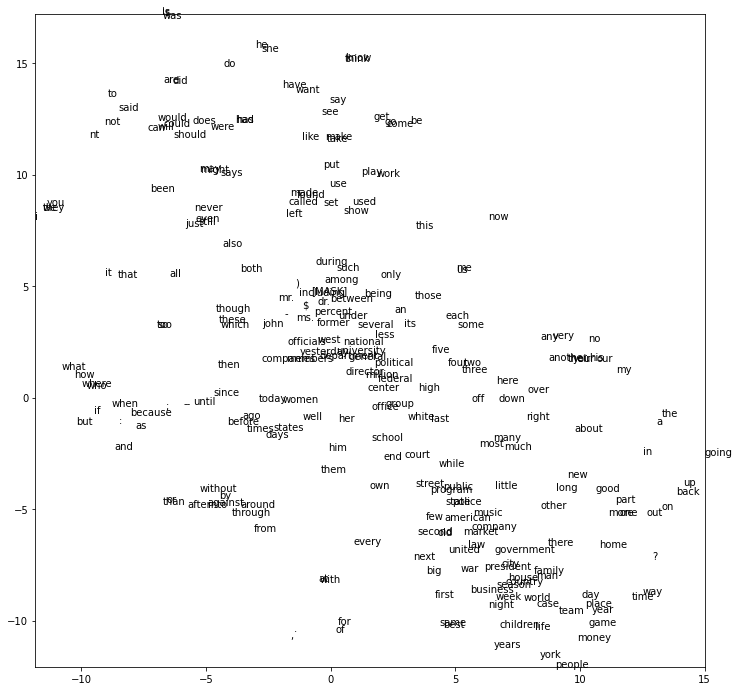

In [121]:
tsne_plot_representation(trained_model)

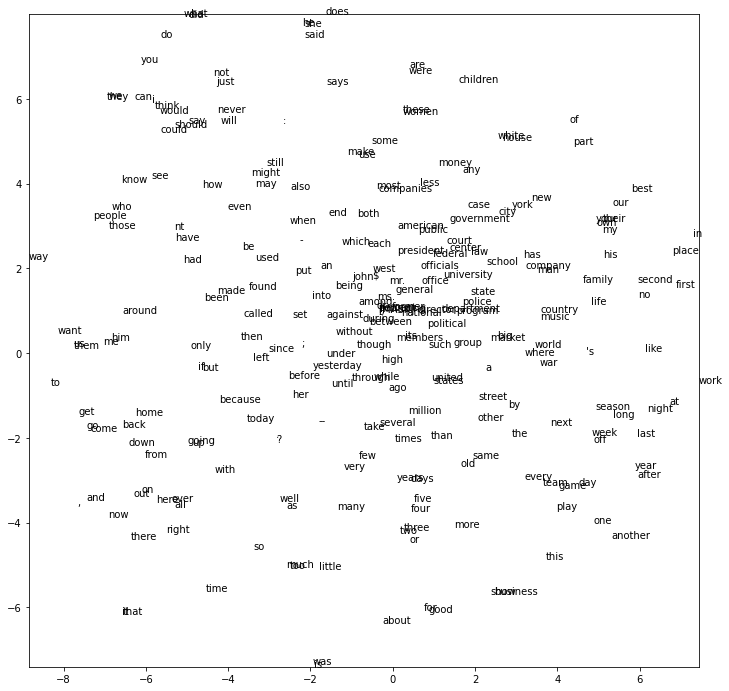

In [122]:
tsne_plot_GLoVE_representation(W_final, b_final)

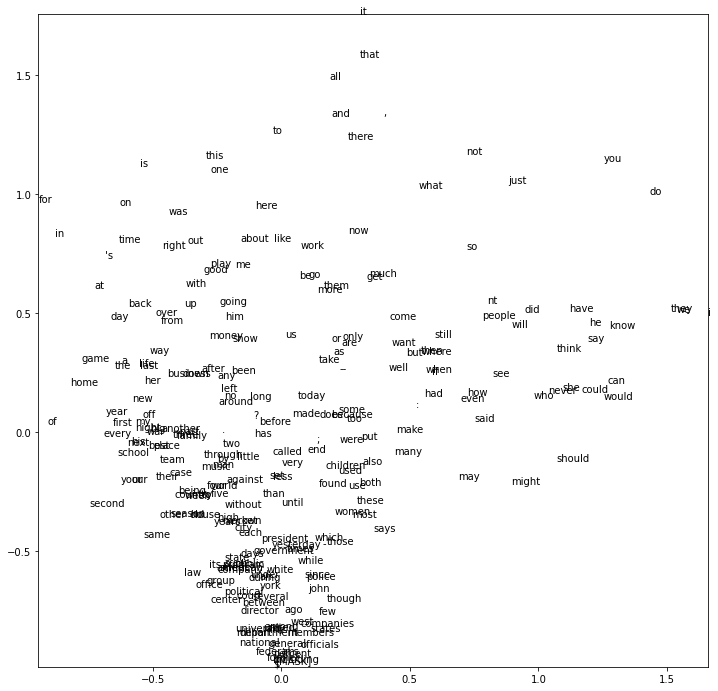

In [123]:
plot_2d_GLoVE_representation(W_final_2d, b_final_2d)

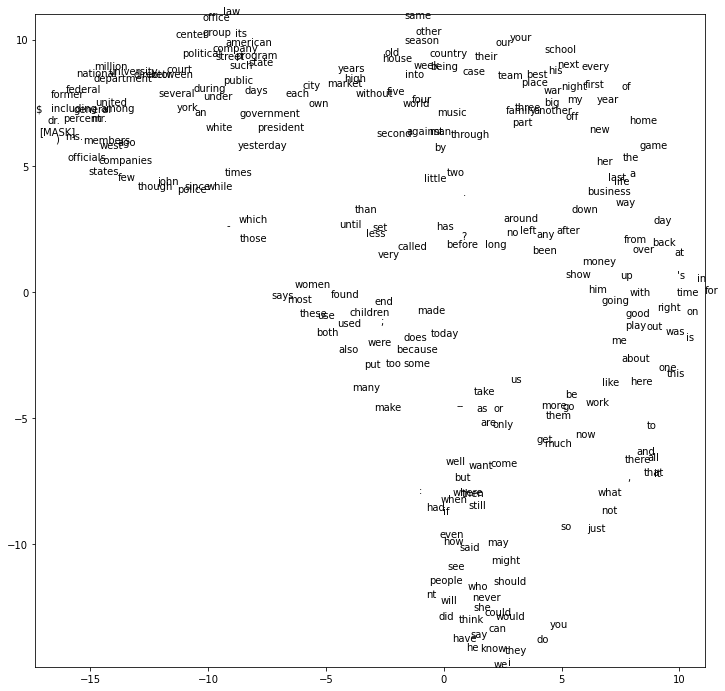

In [124]:
tsne_plot_GLoVE_representation(W_final_2d, b_final_2d)

## 4.2 Word Embedding Arithmetic

A word analogy f is an invertible transformation that holds over a set of ordered pairs S iff $\forall (x,y) \in s, f(x) = y \wedge f^{-1}(y) = x$. When f is of the form $\overrightarrow{\text{x}} \to \overrightarrow{\text{x}} +
         \overrightarrow{\text{r}}$ , it is a linear word analogy.
        
Arithmetic operators can be applied to vectors generated by language models. There is a famous example:
        $\overrightarrow{\text{king}} - \overrightarrow{\text{man}} +
         \overrightarrow{\text{women}} \approx
         \overrightarrow{\text{queen}}$. These linear word analogies form a parallelogram structure in the vector space (Ethayarajh, Duvenaud, \& Hirst, 2019).
        

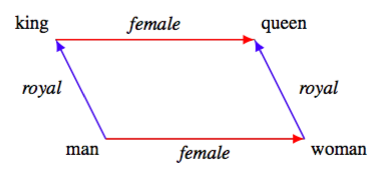

In this section, we will explore a property of *linear word analogies*. A linear word analogy holds exactly over a set of ordered word pairs S iff $\parallel\overrightarrow{\text{x}} - \overrightarrow{\text{y}}\parallel^2$ is the same for every word pair, $\parallel\overrightarrow{\text{a}} - \overrightarrow{\text{x}}\parallel^2 = \parallel\overrightarrow{\text{b}} - \overrightarrow{\text{y}}\parallel^2$ for any two word pairs, and the vectors of all words in S are coplanar.

We will use the embeddings from the symmetric, asymmetrical GloVe model, and the neural network model from part 3 to perform arithmetics. The method to perform the arithmetic and retrieve the closest word embeddings is provided in the notebook using the method `find_word_analogy`:

*   `find_word_analogy` returns the closest word to the word embedding calculated from the 3 given words. 





In [125]:
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.
embedding_dims = 16

W_final_sym, W_tilde_final_asym, W_final_asym = None, None, None
init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
b = init_variance * np.random.normal(size=(vocab_size, 1))
b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))

# Symmetric model
W_final_sym, _, b_final_sym, _ , _, _ = train_GLoVE(W, None, b, None, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)
# Asymmetric model
W_final_asym, W_tilde_final_asym, b_final_asym, b_tilde_final_asym, _, _ = train_GLoVE(W, W_tilde, b, b_tilde, asym_log_co_occurence_train, asym_log_co_occurence_valid, n_epochs, do_print=do_print)


You will need to use different embeddings to evaluate the word analogy

In [126]:
def get_word_embedding(word, embedding_weights):
    assert word in data['vocab'], 'Word not in vocab'
    return embedding_weights[data['vocab'].index(word)]

In [127]:
# word4 = word1 - word2 + word3
def find_word_analogy(word1, word2, word3, embedding_weights):
    embedding1 = get_word_embedding(word1, embedding_weights)
    embedding2 = get_word_embedding(word2, embedding_weights)
    embedding3 = get_word_embedding(word3, embedding_weights)
    target_embedding = embedding1 - embedding2 + embedding3

    # Compute distance to every other word.
    diff = embedding_weights - target_embedding.reshape((1, -1))
    distance = np.sqrt(np.sum(diff ** 2, axis=1))

    # Sort by distance.
    order = np.argsort(distance)[:10]
    print("The top 10 closest words to emb({}) - emb({}) + emb({}) are:".format(word1, word2, word3))
    for i in order:
        print('{}: {}'.format(data['vocab'][i], distance[i]))

In this part of the assignment, you will use the find_word_analogy function to analyze quadruplets from the vocabulary.

### 4.2.1 Specific example
 Perform arithmetic on words *her*, *him*, *her*, using: (1) symmetric, (2) averaging asymmetrical GloVe embedding, (3)  concatenating asymmetrical GloVe embedding, and (4) neural network word embedding from part 3. That is, we are trying to find the closet word embedding vector to the vector 
 
 $$emb(he) - emb(him) + emb(her)$$ 
 
For each sets of embeddings, you should list out: (1) what the closest word that is not one of those three words, and (2) the distance to that closest word. Is the closest word *she*? Compare the results with the tSNE plots.

4.2.1 **Answer**: According to the outputs, we can see that the closest word that are not "he", "him", and "her" is "she" for all $4$ different arithmetic. The corresponding distances are shown below.\\
            According to four plots, they all show the parallelogram property of the quadruplets approximately. The following graphs show how they present for each corresponding plot.

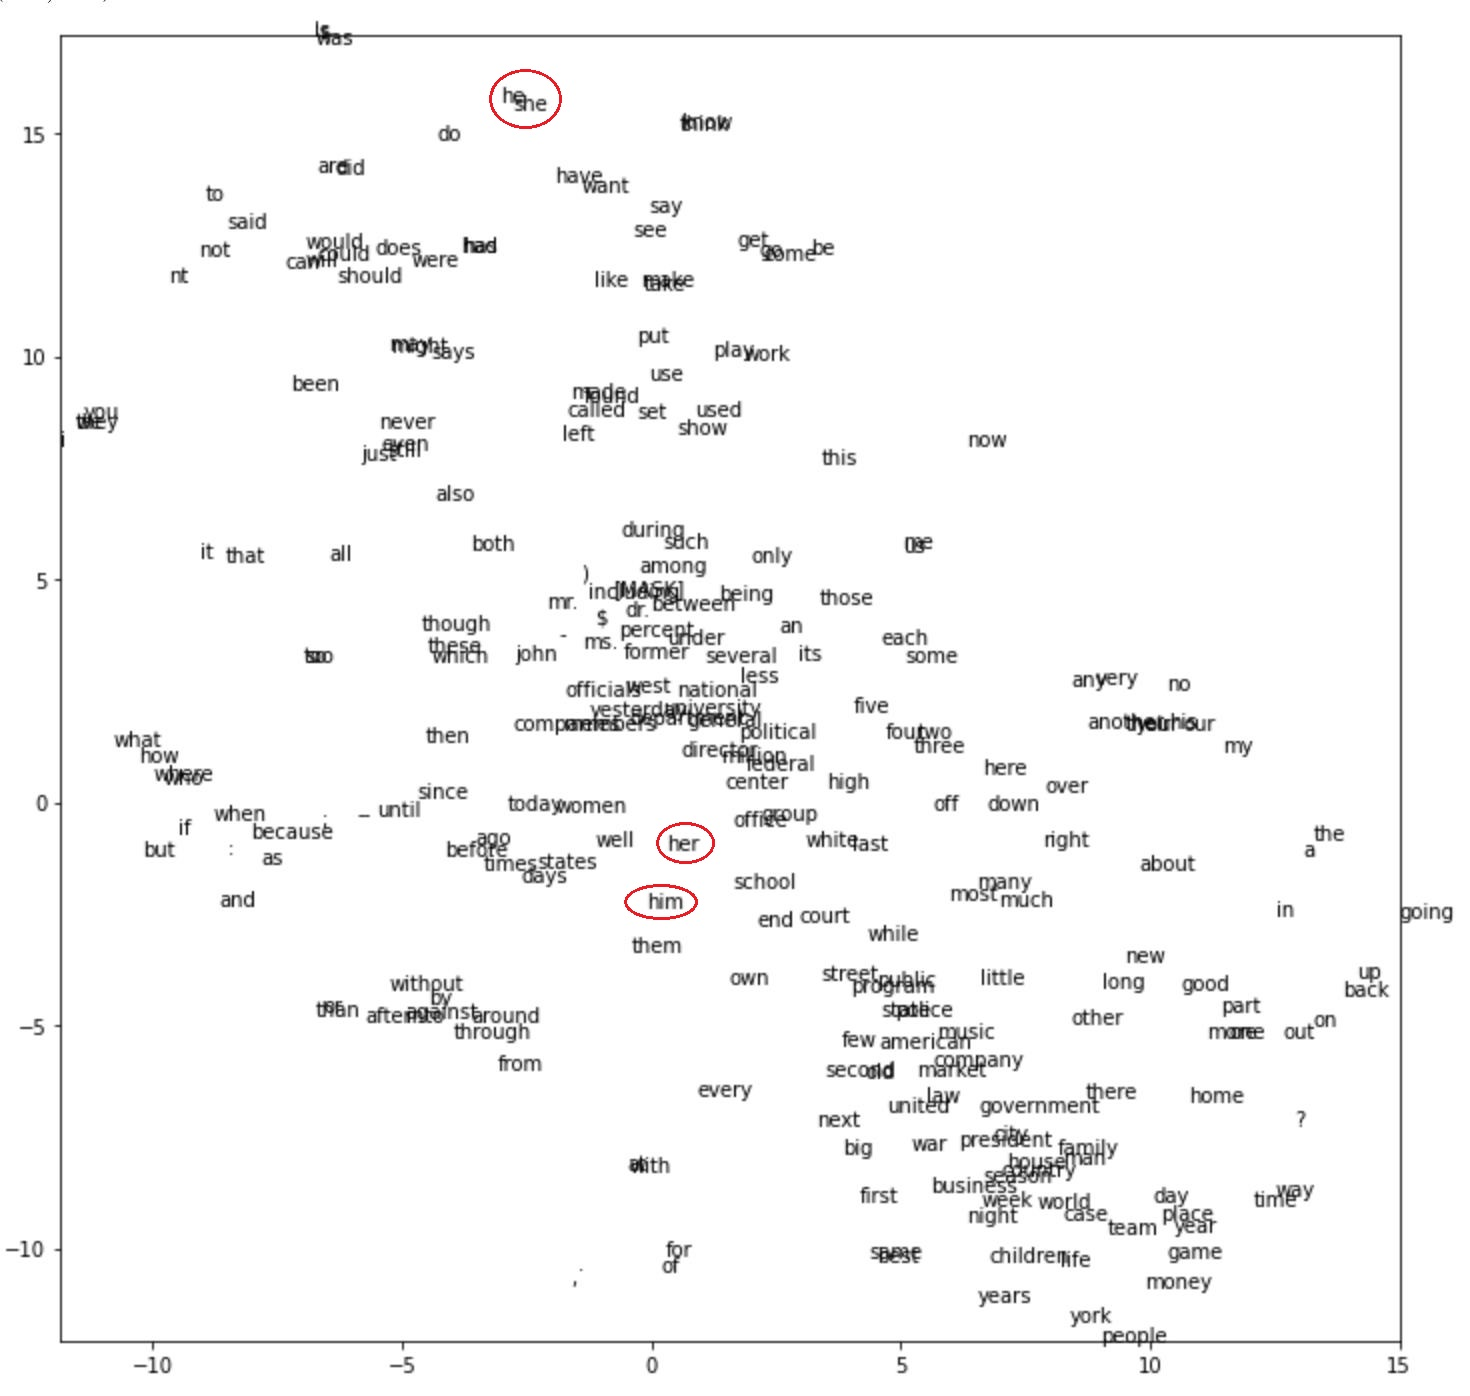

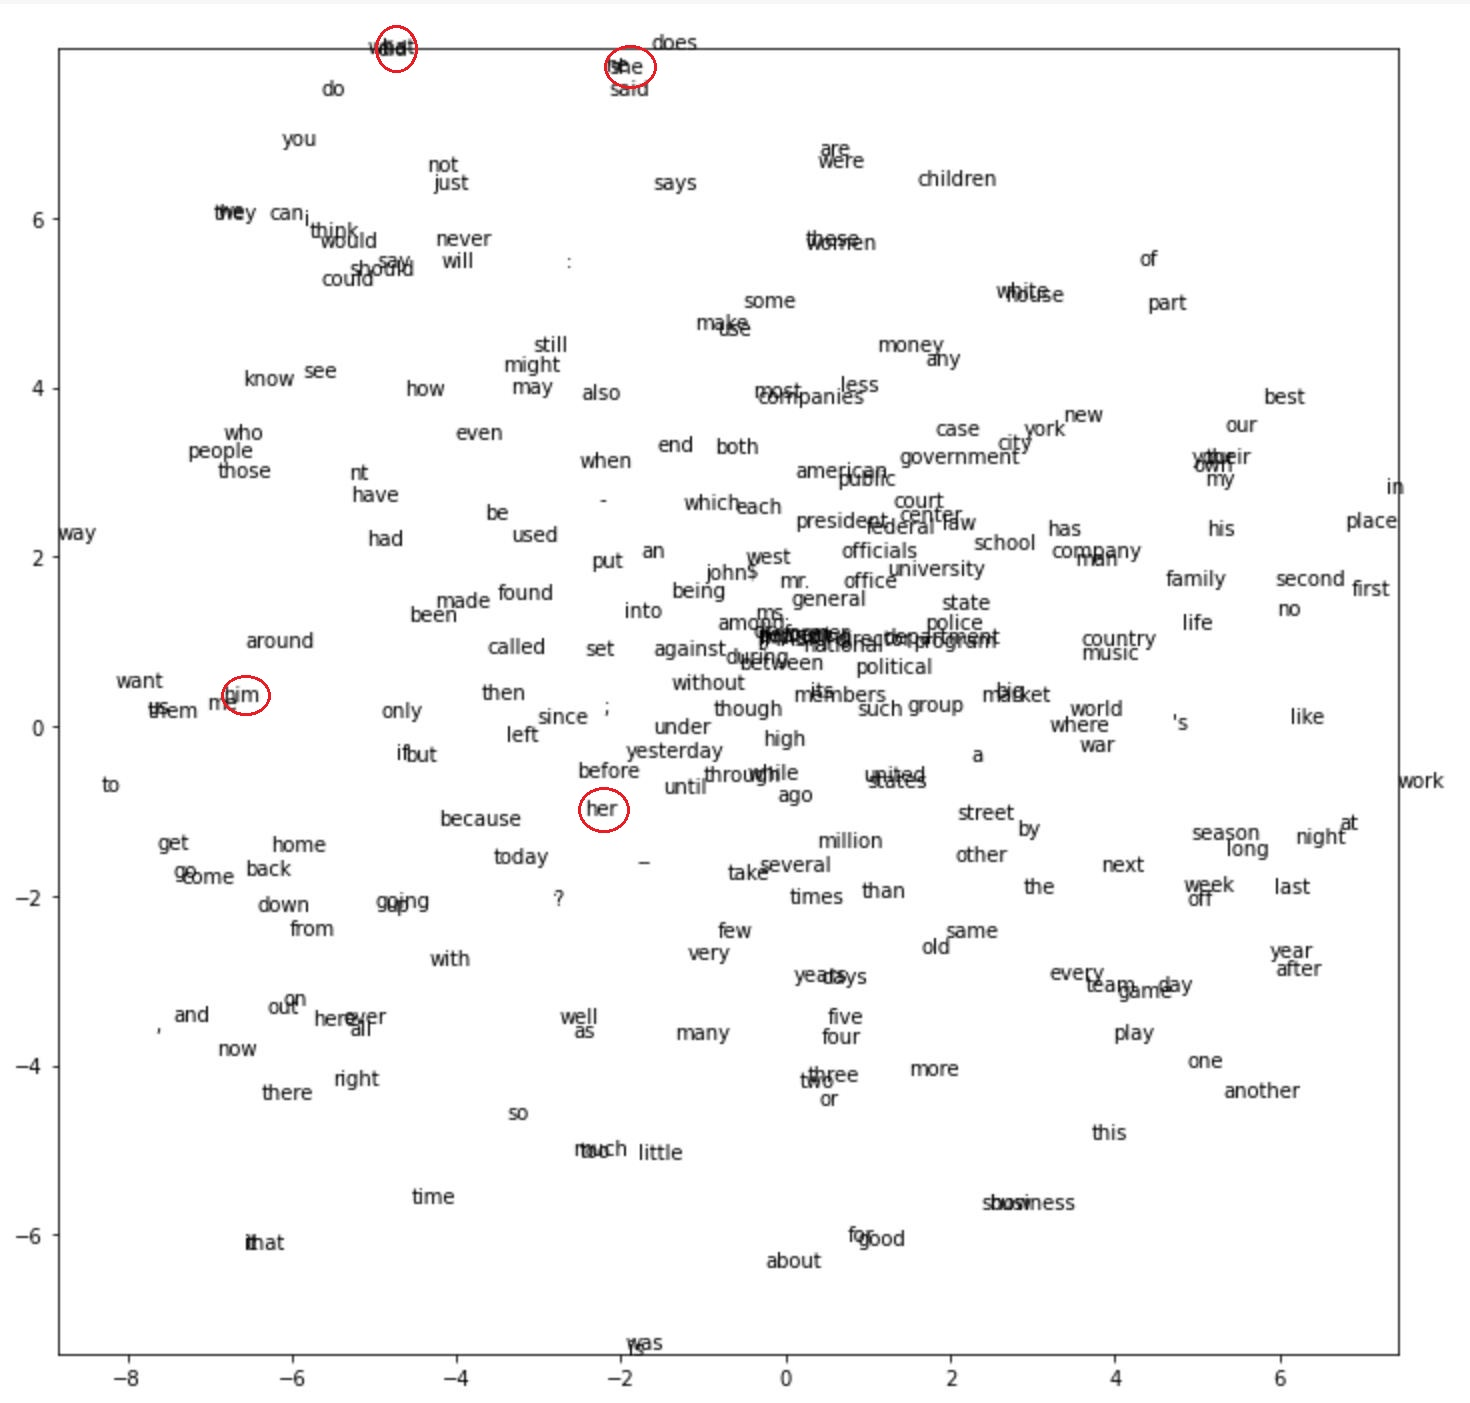

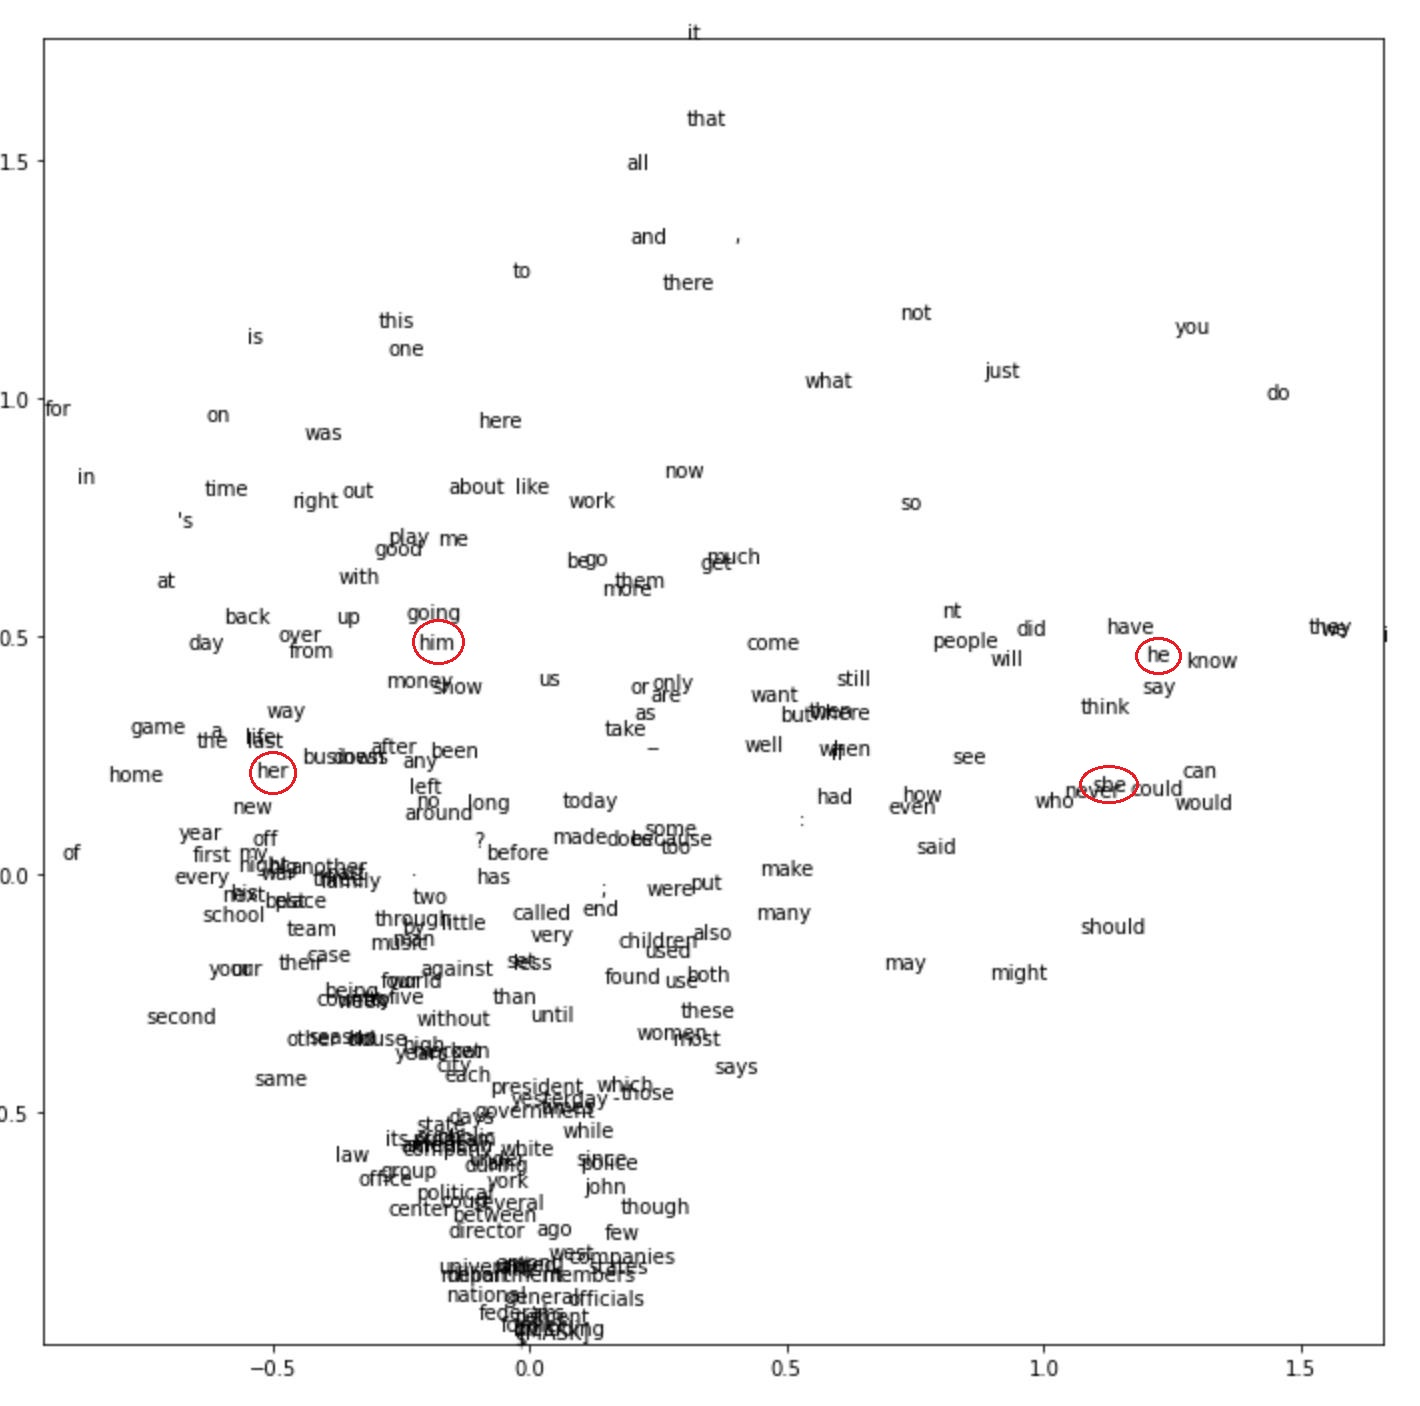

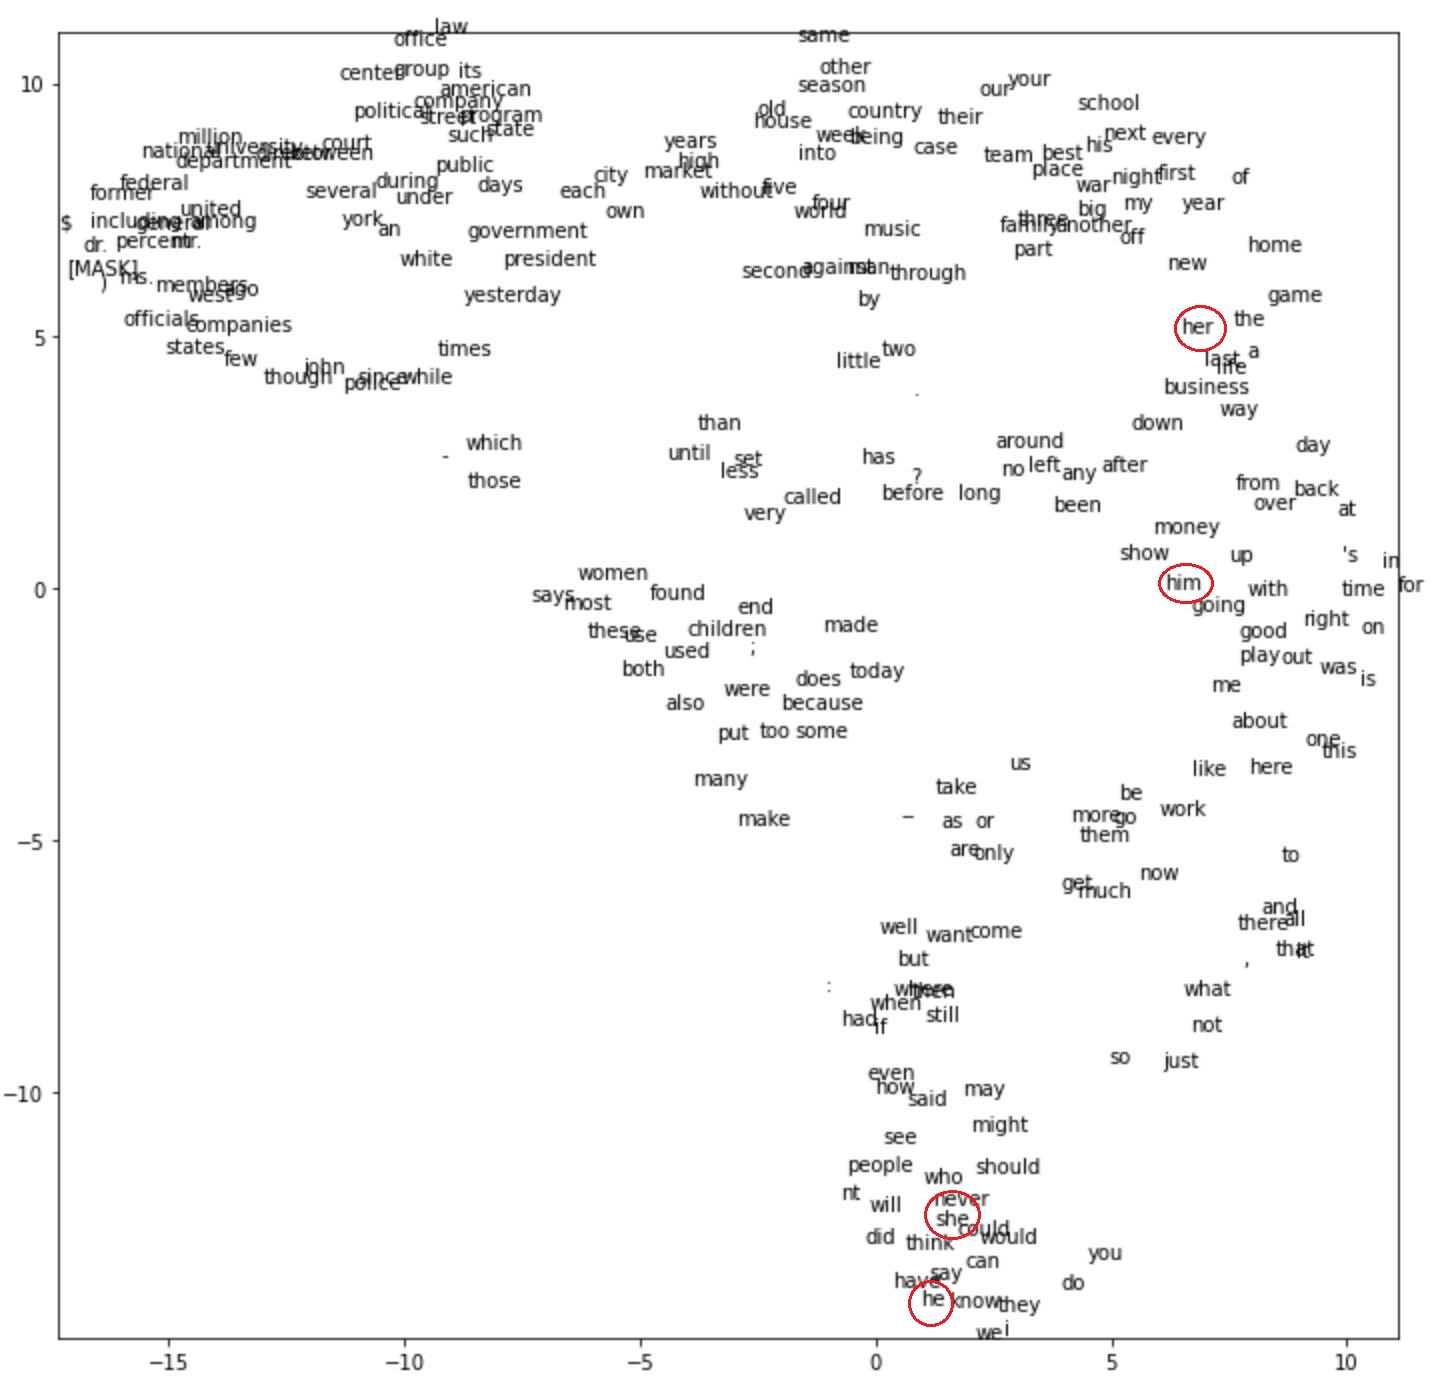

In [128]:
## GloVe embeddings
embedding_weights = W_final_sym # Symmetric GloVe
find_word_analogy('he', 'him', 'her', embedding_weights)

The top 10 closest words to emb(he) - emb(him) + emb(her) are:
he: 1.4213098857979793
she: 1.48167433432594
said: 2.1025960106397767
then: 2.2720425987761406
does: 2.301964867719902
says: 2.318047293286045
who: 2.328984314854128
where: 2.334702431567161
did: 2.353623598835888
should: 2.4126428205989865


In [129]:
# Concatenation of W_final_asym, W_tilde_final_asym
embedding_weights = np.concatenate((W_tilde_final_asym, W_final_asym), axis=1) 
find_word_analogy('he', 'him', 'her', embedding_weights)

The top 10 closest words to emb(he) - emb(him) + emb(her) are:
he: 2.046826000951795
she: 2.3455038844018743
i: 3.0624522787351487
we: 3.2848647174761094
they: 3.390910580609287
you: 4.568945007203308
john: 4.805241000654006
program: 5.084420284826234
president: 5.104152796566877
never: 5.111163924178705


In [130]:
# Averaging asymmetric GLoVE vectors
embedding_weights = (W_final_asym + W_tilde_final_asym)/2 
find_word_analogy('he', 'him', 'her', embedding_weights)

The top 10 closest words to emb(he) - emb(him) + emb(her) are:
he: 1.0154702232698416
she: 1.0744126028585648
should: 1.6078139338035942
could: 1.6799073061855805
i: 1.693953840244398
would: 1.700020962168106
did: 1.766206937557185
can: 1.7744377144463797
might: 1.7765376616413824
will: 1.7931360498829227


In [131]:
## Neural Netework Word Embeddings
embedding_weights = trained_model.params.word_embedding_weights # Neural network from part3
find_word_analogy('he', 'him', 'her', embedding_weights)

The top 10 closest words to emb(he) - emb(him) + emb(her) are:
he: 2.4284684644619032
she: 17.4415802699889
have: 25.921497697983263
they: 25.981587972296392
want: 26.437644546989542
we: 27.128094534488834
i: 27.215833550319473
but: 28.03028938337095
about: 28.163403568035555
this: 28.531350495330678


### 4.2.2 Finding another Quadruplet

Pick another quadruplet from the vocabulary which displays the parallelogram property (and also makes sense sementically) and repeat the above proceduces. Compare and comment on the results from arithmetic and tSNE plots. 

4.2.2 **Answer**: **\*\*TODO: Write Part 4.1 answer here\*\***

In [ ]:
# Repeat above with a different set of words

# What you have to submit

For reference, here is everything you need to hand in. See the top of this handout for submission
directions.



*   A PDF file titled *a1-writeup.pdf* containing the following:
  * [ ] **Part 1**: Questions 1.1, 1.2, 1.3, 1.4. Completed code for `grad_GLoVE` function.
  * [ ] **Part 2**: Questions 2.1, 2.2, 2.3.
  * [ ] **Part 3**: Completed code for `compute_loss_derivative()` (3.1), `back_propagate()` (3.2) functions, and the output of `print_gradients()` (3.3)
  * [ ] **Part 4**: Questions 4.1, 4.2.1, 4.2.2
*   Your code file `a1-code.ipynb`
